In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_privacy
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras import layers
from keras import backend as K
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
tf.random.set_seed(42)

from ctgan import CTGANSynthesizer

D:\Sean\Miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://github.com/sdv-dev/SDGym/issues/44

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32)/255
test_data = np.array(test_data, dtype=np.float32)/255

train_data = train_data.reshape(train_data.shape[0],28,28,1) 
test_data = test_data.reshape(test_data.shape[0],28,28,1)

train_labels = np.array(train_labels, dtype = np.int32)
test_labels = np.array(test_labels, dtype = np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = 10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = 10)

#check data distribution, normalized since divided by 255
assert train_data.min() == 0
assert train_data.max() == 1
assert test_data.min() == 0
assert test_data.max() == 1

## Defining Functions

In [3]:
def dp_sgd(l2_norm_clip,noise_multiplier,num_microbatches,learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,8,
                              strides = 2,
                              padding = 'same',
                              activation = 'relu',
                              input_shape = (28,28,1)),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Conv2D(32,4,
                               strides = 2,
                               padding = 'valid',
                               activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip = l2_norm_clip,
        noise_multiplier = noise_multiplier,
        num_microbatches = num_microbatches,
        learning_rate = learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False, reduction = tf.losses.Reduction.NONE)
    model.compile(optimizer = optimizer , loss = loss, metrics = ['accuracy'])
    return model

def normalmodel():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,8,
                              strides = 2,
                              padding = 'same',
                              activation = 'relu',
                              input_shape = (28,28,1)),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Conv2D(32,4,
                               strides = 2,
                               padding = 'valid',
                               activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False, reduction = tf.losses.Reduction.NONE)
    model.compile(optimizer = optimizer , loss = loss, metrics = ['accuracy'])
    return model

def getlayeroutput(model,data,index):
    from keras import backend as K
    getoutput = K.function([model.layers[0].input],[model.layers[index].output])
    return getoutput([data])[0]

def discriminatortrue(in_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20,input_dim = in_shape,
                              activation = 'linear'),
        tf.keras.layers.Dense(30,activation = 'relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(10,activation = 'linear'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    optimizer = tf.keras.optimizers.SGD()
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                 metrics = 'accuracy')
    return model


def train(distrue, gan, output_noise, output_true):
    
    ### HUGE NOTE: Normalmodel is 1, DPmodel is 0
    
    #train the true discriminator to the DPmodel and Normalmodel data
    distrue_output_true_train_x = output_true[:] #setting x data from normalmodel for true discriminant
    distrue_output_true_train_y = np.ones((output_true.shape[0],1)) #setting y data from normalmodel for true discriminant
    
    distrue_output_noise_train_x = output_noise[:] #setting x data from DPmodel for true discriminant
    distrue_output_noise_train_y = np.zeros((output_noise.shape[0],1)) #setting y data from DPmodel for true discriminant
    
    #combine
    distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
    distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_shuffle, distruey_shuffle = shuffledata(distruex,distruey)
    distrue.fit(distruex_shuffle,distruey_shuffle)
    
    #Initiate GAN
    ###########################################################################################################      
    ##GAN PART
    gan.fit(output_true)
    fake = gan.sample(output_true.shape[0])
    ########################################################################################################### 
    #final accuracy of True Discriminant
    output_true_upsampled_x = fake[:]
    output_true_upsampled_y = np.ones((output_true_upsampled_x.shape[0],1))
    
    output_noise_x, output_noise_y = output_noise[:], np.zeros((output_noise.shape[0],1))
    
    distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
    distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_final_shuffle, distruey_final_shuffle = shuffledata(distruex_final,distruey_final)
    pred = distrue.predict(distruex_final_shuffle)  

    fin_acc = accuracy_score(np.array(distruey_final_shuffle), pred)
    print("Final True Discriminant Accuracy: %.3f" % fin_acc)
    

def shuffledata(xdata,ydata):
    indices = tf.range(start=0,limit=tf.shape(xdata)[0], dtype = tf.int32)
    idx = tf.random.shuffle(indices)
    return tf.gather(xdata,idx) , tf.gather(ydata,idx)

## Training Original Model 

##### DPmodel & Normalmodel

In [4]:
DPmodel = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 0.1, 
                 num_microbatches = 50, learning_rate = 0.25)
Normalmodel = normalmodel()

DPmodel.fit(train_data, train_labels, 
            epochs = 5, batch_size = 250,
            validation_data = (test_data, test_labels))

Normalmodel.fit(train_data, train_labels, 
                epochs = 5, batch_size = 250,
                validation_data = (test_data, test_labels))

Epoch 1/5
240/240 [==============================] - 29s 101ms/step - loss: 0.6780 - accuracy: 0.7840 - val_loss: 0.2344 - val_accuracy: 0.9332
Epoch 2/5
240/240 [==============================] - 24s 100ms/step - loss: 0.2034 - accuracy: 0.9430 - val_loss: 0.1628 - val_accuracy: 0.9554
Epoch 3/5
240/240 [==============================] - 25s 103ms/step - loss: 0.1546 - accuracy: 0.9579 - val_loss: 0.1179 - val_accuracy: 0.9681
Epoch 4/5
240/240 [==============================] - 24s 99ms/step - loss: 0.1297 - accuracy: 0.9660 - val_loss: 0.1215 - val_accuracy: 0.9687
Epoch 5/5
240/240 [==============================] - 24s 100ms/step - loss: 0.1166 - accuracy: 0.9697 - val_loss: 0.1162 - val_accuracy: 0.9694
Epoch 1/5
240/240 [==============================] - 2s 7ms/step - loss: 0.4695 - accuracy: 0.8591 - val_loss: 0.1312 - val_accuracy: 0.9595
Epoch 2/5
240/240 [==============================] - 2s 7ms/step - loss: 0.1114 - accuracy: 0.9661 - val_loss: 0.0758 - val_accuracy: 0.9759

In [5]:
DPmodel = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 0.1, 
                 num_microbatches = 50, learning_rate = 0.25)


##### DP Model Privacy

In [6]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=250,
                                              noise_multiplier=0.1,
                                              epochs=5,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 0.1 iterated over 1200 steps satisfies differential privacy with eps = 4.22e+04 and delta = 1e-05.
The optimal RDP order is 1.25.
The privacy estimate is likely to be improved by expanding the set of orders.


(42160.45465553471, 1.25)

##### Normal Model Privacy

In [7]:
#compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
#                                              batch_size=250,
#                                              noise_multiplier=0.1,
#                                              epochs=5,
#                                              delta=1e-5)

## Proceed with GAN

In [8]:
output_model_noise = DPmodel.predict(train_data)
output_model_true = Normalmodel.predict(train_data)

1875/1875 [==============================] - 5s 3ms/step


In [9]:
#for i in range(0,5):
#    findisc = RandomForestClassifier(random_state = 42)
#    gan = CTGANSynthesizer(epochs = 50, verbose = True, cuda = True)
#    train(findisc,gan,output_model_noise,output_model_true)
    
findisc = RandomForestClassifier(random_state = 42)
gan = CTGANSynthesizer(epochs = 50, verbose = True, cuda = True)
train(findisc,gan,output_model_noise,output_model_true)

C:\Windows\Temp\ipykernel_21156\300499000.py:86: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_21156\300499000.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_21156\300499000.py:91: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  distrue.fit(distruex_shuffle,distruey_shuffle)
D:\Sean\Miniconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did n

Epoch 1, Loss G: -0.6559,Loss D: -0.1074
Epoch 2, Loss G: -1.6369,Loss D:  0.0276
Epoch 3, Loss G: -2.0741,Loss D:  0.0290
Epoch 4, Loss G: -2.3072,Loss D:  0.1429
Epoch 5, Loss G: -2.5106,Loss D: -0.1795
Epoch 6, Loss G: -2.5632,Loss D: -0.1219
Epoch 7, Loss G: -3.0463,Loss D: -0.0025
Epoch 8, Loss G: -2.7125,Loss D: -0.0816
Epoch 9, Loss G: -2.8575,Loss D:  0.0327
Epoch 10, Loss G: -3.0935,Loss D: -0.1160
Epoch 11, Loss G: -3.2341,Loss D:  0.0841
Epoch 12, Loss G: -2.9526,Loss D: -0.0317
Epoch 13, Loss G: -2.6034,Loss D: -0.3275
Epoch 14, Loss G: -2.1723,Loss D:  0.0197
Epoch 15, Loss G: -2.3353,Loss D: -0.1516
Epoch 16, Loss G: -1.5859,Loss D:  0.0643
Epoch 17, Loss G: -1.0930,Loss D: -0.0507
Epoch 18, Loss G: -0.8086,Loss D:  0.0875
Epoch 19, Loss G: -0.5707,Loss D: -0.0800
Epoch 20, Loss G: -0.5777,Loss D: -0.0499
Epoch 21, Loss G: -0.0696,Loss D: -0.0582
Epoch 22, Loss G: -0.4248,Loss D:  0.0915
Epoch 23, Loss G: -0.1148,Loss D: -0.0343
Epoch 24, Loss G: -0.1987,Loss D: -0.1586
E

C:\Windows\Temp\ipykernel_21156\300499000.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_21156\300499000.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()


Final True Discriminant Accuracy: 1.000


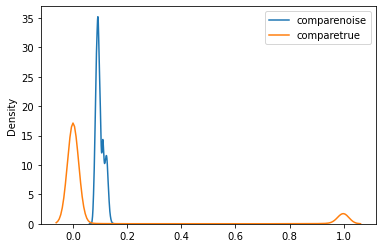

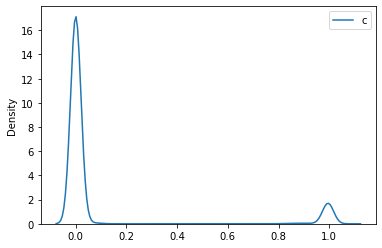

In [10]:
fake = gan.sample(output_model_true.shape[0])
comparenoise = output_model_noise.flatten()
comparetrue = output_model_true.flatten()
comparefake = fake.flatten()
sns.kdeplot(comparenoise)
sns.kdeplot(comparetrue)
plt.legend(labels = ['comparenoise','comparetrue'])
plt.show()
sns.kdeplot(comparefake)
plt.legend(labels = 'comparefake')
plt.show()

In [11]:
from scipy.stats import ttest_ind

ttest_ind(comparetrue,comparefake)

Ttest_indResult(statistic=1.6565991246672493, pvalue=0.09760081089066062)

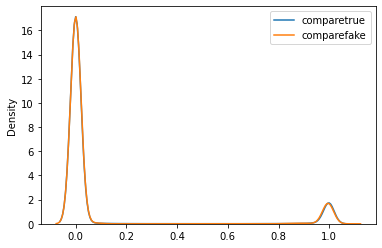

In [12]:
sns.kdeplot(comparetrue)
sns.kdeplot(comparefake)
plt.legend(labels = ['comparetrue','comparefake'])